In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import whitw
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
import pandas as pd
import math
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import fsolve
import os
from importlib import reload
import utilities
reload(utilities)
import GEFClassic
reload(GEFClassic)
from GEFClassic import GEF
#from utilities import PlotComp
#from utilities import EndOfInflation

In [2]:
def ModeEoM(A, k, dphidt, dIdphi, a):
    #omega=1.
    dAdt = np.zeros(A.size)
    
    drag = 0#a**(-alpha) * sigmaE
    dis1 = k * a**(alpha-1)
    dis2 = dIdphi * dphidt# + a**(alpha)*sigmaB

    #positive helicity
    lam = 1.
    #Real Part
    dAdt[0] = A[1]*(k/a)*a**(alpha)
    dAdt[1] = -( drag * A[1] + (dis1  - lam * dis2) * A[0] )
    
    #Imaginary Part
    dAdt[2] = A[3]*(k/a)*a**(alpha)
    dAdt[3] = -( drag * A[3] + (dis1  - lam * dis2) * A[2] )
    
    
    #negative helicity
    lam = -1.
    #Real Part
    dAdt[4] = A[5]*(k/a)*a**(alpha)
    dAdt[5] = -( drag * A[5] + (dis1  - lam * dis2) * A[4] )
    
    #Imaginary Part
    dAdt[6] = A[7]*(k/a)*a**(alpha)
    dAdt[7] = -( drag * A[7] + (dis1  - lam * dis2) * A[6] )
    
    return dAdt

In [3]:
def ModeByMode(tmin, tmax, tend, kh, dphidt, dIdphi, a, steps=100, cut=0.1, save=False):
    dt = (tmax-tmin)/(steps)
    ts = np.arange(tmin, tend, dt)        
    
    Ap = []
    dApdt = []
    Am = []
    dAmdt = []
    ks = []
    for i in range(1,steps):
        s = ts[i]
        if (kh(s)/kh(ts[i-1]) > cut): 
            k = 10**(5/2)*kh(s)

            #t1 = Timer()
            ks.append(k)
        
            #t1.start()
            Aini = np.array([1., 0, 0, -1., 1, 0, 0, -1.])
            ode = lambda x, y: ModeEoM(y, k, dphidt(x), dIdphi, a(x))
            
            sol = solve_ivp(ode, [s, ts[-1]], Aini, t_eval=ts[i:], method="RK45", atol=1e-8, rtol=1e-8)
            
            #vacuum will not contribute to integrals, so we set this part to 0 to have equal length arrays
            vac = list((1+0j)*np.ones((i)))
            dvacdt = list((0.-1j)*np.ones((i)))
            
            Aptmp = list(np.array(sol.y[0,:]) + np.array(sol.y[2,:])*1j)
            Ap.append([*vac, *Aptmp])
            
            dAptmp = list(np.array(sol.y[1,:]) + np.array(sol.y[3,:])*1j)
            dApdt.append([*dvacdt, *dAptmp])
            
            
            Amtmp = list(np.array(sol.y[4,:]) + np.array(sol.y[6,:])*1j)
            Am.append([*vac, *Amtmp])
            
            dAmtmp = list(np.array(sol.y[5,:]) + np.array(sol.y[7,:])*1j)
            dAmdt.append([*dvacdt, *dAmtmp])

            #t1.stop()
        else:
            print("skip")
            continue
            
    Ap = np.array(Ap)
    dApdt = np.array(dApdt)            
    Am = np.array(Am)
    dAmdt = np.array(dAmdt)

    if save:
        SaveMode(ts, ks, Ap, dApdt, Am, dAmdt, af)
                   
    
    return Ap, dApdt, Am, dAmdt, ks, ts

In [4]:
def SaveMode(t, k, Ap, dAp, Am, dAm, af, name=None):
    logk = np.log10(k)
    N = list(np.log(af(t)))
    N = np.array([np.nan]+N)
    t = np.array([np.nan]+list(t))
    dic = {"t":t}
    dic = dict(dic, **{"N":N})
    for k in range(0, len(Ap[:,0])):
        dictmp = {"Ap_" + str(k) :np.array([logk[k]] + list(Ap[k,:]))}
        dic = dict(dic, **dictmp)
        dictmp = {"Am_" + str(k) :np.array([logk[k]] + list(dAp[k,:]))}
        dic = dict(dic, **dictmp)
        dictmp = {"dAp_" + str(k):np.array([logk[k]] + list(Am[k,:]))}
        dic = dict(dic, **dictmp)
        dictmp = {"dAm_" + str(k):np.array([logk[k]] + list(dAm[k,:]))}
        dic = dict(dic, **dictmp)
        
    if(name==None):
        filename = "Modes+Beta" + str(beta) + "+M6_16" +  + ".dat"
    else:
        filename = name

    DirName = os.getcwd()

    path = os.path.join(DirName, filename)

    output_df = pd.DataFrame(dic)  
    output_df.to_csv(path)
    
    return

def ReadModeFile(file):
    input_df = pd.read_table(file, sep=",")
    dataAp = input_df.values

    x = np.arange(3,dataAp.shape[1], 4)
    
    t = np.array(dataAp[1:,1])
    N = np.array(dataAp[1:,2])
    logk = np.array([(complex(dataAp[0,y])).real for y in x])
    Ap = np.array([[complex(dataAp[i+1,y]) for i in range(len(N))] for y in x])
    dAp = np.array([[complex(dataAp[i+1,y+1]) for i in range(len(N))] for y in x])
    Am = np.array([[complex(dataAp[i+1,y+2]) for i in range(len(N))] for y in x])
    dAm = np.array([[complex(dataAp[i+1,y+3]) for i in range(len(N))] for y in x])
    
    return t, N, logk, Ap, dAp, Am, dAm
    

In [5]:
def EBGnIntegrandMode(k, A1, A2, lam, a, n):
    
    Eterm = abs(A2)**2
    
    Bterm = abs(A1)**2
    
    Gterm = lam*(A1.conjugate() * A2).real
    
    #prefac modified to account for sqrt(2k) factor in modes
    prefac = lam**n * 1/(2*np.pi)**2 * (k/a)**(n+3)/a
    
    #ErotnE = int(Edk) 
    E = prefac * Eterm
    
    #BrotnB = int(Bdk) 
    B = prefac * Bterm
    
    #-ErotnB = int(Gdk)
    G = prefac * Gterm
    return E, B, G

def ComputeEBGnMode(AP, AM, dAP, dAM, a, ks, kh, n):
    #AP AM dAP, dAM are sqrt(2k)Ap etc.
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
    
    En, Bn, Gn = 0, 0, 0
    
    for k in range(1,m):
        if (ks[k-1]<kh):
            #print(kh)
            dk = ks[k]-ks[k-1]
            En += dk*(Es[k] + Es[k-1])/2
            Bn += dk*(Bs[k] + Bs[k-1])/2
            Gn += dk*(Gs[k] + Gs[k-1])/2
        else:
            return En, Bn, Gn

    return En, Bn, Gn

def ComputeEBGnModeInterp(AP, AM, dAP, dAM, a, ks, kh, n):
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
        
    Es = np.array(Es)
    Bs = np.array(Bs)
    Gs = np.array(Gs)
        
    E = lambda x: CubicSpline(ks, Es)(x)
    B = lambda x: CubicSpline(ks, Bs)(x)
    G = lambda x: CubicSpline(ks, Gs)(x)
    
    kmin = min(ks)
    
    En = quad(E, kmin, kh)[0]
    Bn = quad(B, kmin, kh)[0]
    Gn = quad(G, kmin, kh)[0]

    return En, Bn, Gn

In [17]:
def RunMBM(G, Nstart, EarlyModes=200, LateModes=800, cut=0.01, save=None):
    #data = input_df.values
    omega = G.H0
    NR = G.vals["N"]
    tR = G.vals["t"]
    aR = G.vals["a"]
    khR = G.vals["kh"]
    dphidtR = G.vals["dphi"]
    dI = G.dIdphi()
    af = CubicSpline(tR, aR)
    dphidtf = CubicSpline(tR, dphidtR)
    khf = CubicSpline(tR, khR)

    maxkh = max(khR)*10**(-3/2)

    start = False
    stop = False
    i = 0
    while(not(start and stop)):
        N = NR[i]
        kh = khR[i+1]
        if (Nstart>N):
            tini = tR[i]
        else:
            start = True
        if (kh<maxkh):
            tend = tR[i+1]
        else:
            stop = True
        i += 1
        
    print(tini, tend)
    print(np.log(af(tini)), np.log(af(tend)))

    Ap1, dAp1, Am1, dAm1, ks1, ts1 = ModeByMode(1, tini, tR[-25], khf, dphidtf, dI, af, steps=EarlyModes, cut=cut)
    print("Low wavenumber modes computed")
    Ap2, dAp2, Am2, dAm2, ks2, ts = ModeByMode(tini, tend, tR[-25], khf, dphidtf, dI, af, steps=LateModes, cut=cut)
    print("High wavenumber modes computed")
    #Only Mode-functions after Nstart are returned and stored
    Ap = np.array([*[CubicSpline(ts1, Ap1[i,:])(ts) for i in range(len(ks1))], *list(Ap2)])
    dAp = np.array([*[CubicSpline(ts1, dAp1[i,:])(ts) for i in range(len(ks1))], *list(dAp2)])
    Am = np.array([*[CubicSpline(ts1, Am1[i,:])(ts) for i in range(len(ks1))], *list(Am2)])
    dAm = np.array([*[CubicSpline(ts1, dAm1[i,:])(ts) for i in range(len(ks1))], *list(dAm2)])
    ks = np.array([*list(ks1), *list(ks2)])
    
    if(save != None):
        SaveMode(ts, ks, Ap, dAp, Am, dAm, af, name=save+".dat")
        
    Ns = np.log(af(ts))
    khs = khf(ts)
    print("All Done")
    return ts, Ns, ks, khs, Ap, dAp, Am, dAm, 

In [18]:
alpha = 0
beta = 10.
Mpl = 1.
M = 6.16e-6*Mpl
phi0 = 15.55*Mpl
dphidt0 = -np.sqrt(2/3)*M*Mpl
ini = {"phi":phi0, "dphi":dphidt0}
ntr = 50

name = f"_Beta{beta}_SENone_M6.16"

H = GEF(beta, Mpl, ini, M, ntr, approx=True)

file = "Out/GEF"+name+".dat"
H.LoadData(file) 

ts, Ns, ks, khs, Ap, dAp, Am, dAm = RunMBM(H, 30., EarlyModes=200, LateModes=800)

35.047186458056295 93.2405189253874
29.998284643291246 57.607773093016085
Low wavenumber modes computed
High wavenumber modes computed
All Done


In [19]:
EMode = []
BMode = []
GMode = []
#print(Ap[60,:])
#print(ts.size)
for i in range(len(ts)):
    Etmp, Btmp, Gtmp = ComputeEBGnMode(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i], np.exp(Ns[i]), ks, khs[i], 0)
    EMode.append(Etmp)
    BMode.append(Btmp)
    GMode.append(Gtmp)
    
EMode1 = np.array(EMode)
BMode1 = np.array(BMode)
GMode1 = np.array(GMode)

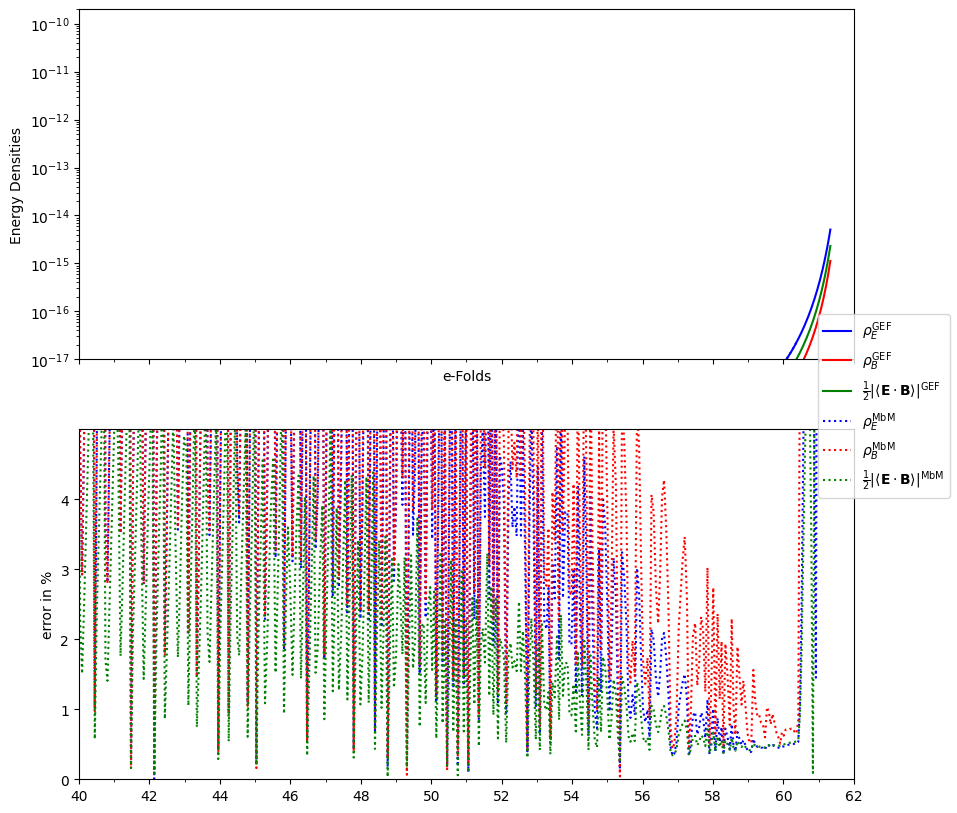

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
ER = H.vals["E"]
BR = H.vals["B"]
GR = H.vals["G"]
NR = H.vals["N"]
omega = H.H0
rhoE = 0.5*ER*omega**4
errE = abs(ER - CubicSpline(Ns, EMode1)(NR))/CubicSpline(Ns, EMode1)(NR)
rhoB = 0.5*BR*omega**4
errB = abs(BR - CubicSpline(Ns, BMode1)(NR))/CubicSpline(Ns, BMode1)(NR)
rhoG = 0.5*abs(GR)*omega**4
errG = (abs(GR) - CubicSpline(Ns, abs(GMode1))(NR))/CubicSpline(Ns, abs(GMode1))(NR)

#xticks = np.arange(36, 57, 2)
#xticksmin = np.arange(35, 58, 2)
xticks = np.arange(40, 64, 2)
xticksmin = np.arange(41, 63, 2)
yticks = 10**(-1.*np.arange(14, 17))

ax[0].plot(NR, rhoE, "b", label=r"$\rho_E^{\mathrm{GEF}}$")
ax[0].plot(NR, rhoB, "r", label=r"$\rho_B^{\mathrm{GEF}}$")
ax[0].plot(NR, rhoG, "g", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|^{\mathrm{GEF}}$")
ax[0].plot(Ns, 0.5*EMode1*omega**4, "b:", label=r"$\rho_E^{\mathrm{MbM}}$")
ax[0].plot(Ns, 0.5*BMode1*omega**4, "r:", label=r"$\rho_B^{\mathrm{MbM}}$")
ax[0].plot(Ns, 0.5*abs(GMode1)*omega**4, "g:", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|^{\mathrm{MbM}}$")
#ax[0].vlines(NEnd, ymin=1e-17, ymax=2e-14, colors="k", linestyles="dotted")
ax[0].set_ylim(1e-17, 2e-10)
ax[0].set_xlim(40, 62)

ax[0].set_xticks(xticks)
ax[0].set_xticks(xticksmin, minor=True)
ax[0].set_yticks(yticks)
ax[0].set_ylabel("Energy Densities")
ax[1].set_ylabel("error in %")
ax[0].set_xlabel("e-Folds")
ax[0].set_xlabel("e-Folds")
ax[0].set_yscale("log")
ax[1].plot(NR, abs(errE*100), "b:")
ax[1].plot(NR, abs(errB*100), "r:")
ax[1].plot(NR, abs(errG*100), "g:")
ax[1].set_ylim(0.,5)
#ax[1].vlines(NEnd, ymin=0, ymax=50, colors="k", linestyles="dotted")
ax[1].set_yticks(np.arange(0,5,1))
lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=5)


In [66]:
fig.savefig("Plots/MbM" + name + ".png")

In [17]:
file = "Modes/MbM" + name + ".dat"
SaveMode(ts, ks, Ap, dAp, Am, dAm, af, name=file)